In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# '\s+' tells pandas to use any spaces as the delimiter instead of ,
original_data = pd.read_csv("../data/delivery.2024.04.16.dat", delimiter='\s+')

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3364755/3529069451.py:2: SyntaxWarning: invalid escape sequence '\s'
  original_data = pd.read_csv("../data/delivery.2024.04.16.dat", delimiter='\s+')


In [3]:
feature_col_names = ['F01', 'F04', 'F06', 'F09','F13']

In [4]:
# Remove gis examples
filtered_data = original_data.drop(np.where(original_data['Tag'] == 'gis')[0])
filtered_data["Tag"].value_counts()

Tag
eq     5837
mis    2043
ex     1540
Name: count, dtype: int64

In [5]:
# Remove rows with missing features
filtered_data = filtered_data[np.all(filtered_data[feature_col_names] != "X", axis=1)]
filtered_data["Tag"].value_counts()

Tag
eq     1192
ex      304
mis     196
Name: count, dtype: int64

In [6]:
X_df = filtered_data[feature_col_names].astype(float)

In [7]:
# LabelEncoder will transform the class names to numeric values
le = LabelEncoder()
le.fit(filtered_data['Tag'])
print("Original Classes", le.classes_)
print("Mapping", le.transform(le.classes_))
le.classes_ = np.array(['ex', 'eq', 'mis'])
print("Updated Classes", le.classes_)
print("Mapping", le.transform(le.classes_))
y = le.transform(filtered_data['Tag'])
y_cnts = np.unique(y, return_counts=True)[1]
print(y_cnts)

Original Classes ['eq' 'ex' 'mis']
Mapping [0 1 2]
Updated Classes ['ex' 'eq' 'mis']
Mapping [0 1 2]
[ 304 1192  196]


In [8]:
train_inds, test_inds = train_test_split(np.arange(X_df.shape[0]), 
                                         test_size=0.2, 
                                         shuffle=True,
                                         random_state=42,
                                         stratify=y)

In [9]:
X_df = X_df.to_numpy()
X_train = X_df[train_inds]
X_test = X_df[test_inds]
y_train = y[train_inds]
y_test = y[test_inds]

In [10]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print("Actual class percentage:", y_cnts/len(y))
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))

Training: (1353, 5) (1353,)
Testing: (339, 5) (339,)
Actual class percentage: [0.17966903 0.70449173 0.11583924]
Training class percentage: [0.17960089 0.70436068 0.11603843]
Testing class percentage: [0.179941   0.70501475 0.11504425]


# Remove outliers in the training and testing sets 
remove rows with any features > the 99 percentile or < the 1 percentile of that feature in the training set


In [11]:
low_percentile, high_percentile = np.percentile(X_train, [1, 99], axis=0)
train_inds_to_drop = np.unique((np.concatenate([np.where(X_train >  high_percentile)[0],
                                          np.where(X_train < low_percentile)[0]])))
test_inds_to_drop = np.unique((np.concatenate([np.where(X_test >  high_percentile)[0],
                                          np.where(X_test < low_percentile)[0]])))
print(train_inds_to_drop.shape, test_inds_to_drop.shape)

(126,) (30,)


In [12]:
filtered_train_inds = np.delete(train_inds, train_inds_to_drop)
filtered_test_inds = np.delete(test_inds, test_inds_to_drop)
X_train = X_df[filtered_train_inds]
X_test = X_df[filtered_test_inds]
y_train = y[filtered_train_inds]
y_test = y[filtered_test_inds]

In [13]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print("Actual class percentage:", y_cnts/len(y))
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))

Training: (1227, 5) (1227,)
Testing: (309, 5) (309,)
Actual class percentage: [0.17966903 0.70449173 0.11583924]
Training class percentage: [0.16788916 0.7196414  0.11246944]
Testing class percentage: [0.16828479 0.72168285 0.11003236]


# Train model

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [15]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
model = LinearDiscriminantAnalysis()

In [17]:
model.fit(X_train_scaled, y_train)

LinearDiscriminantAnalysis()

# Train results

In [18]:
y_pred_train = model.predict(X_train_scaled)

In [19]:
cm = confusion_matrix(y_train, y_pred_train)
print(cm)

[[175  12  19]
 [ 14 869   0]
 [ 12   0 126]]


In [20]:
f1_score(y_train, y_pred_train, average='macro')

0.9118903316278381

# Testing results

In [21]:
y_pred_test = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

[[ 45   2   5]
 [  2 221   0]
 [  1   0  33]]


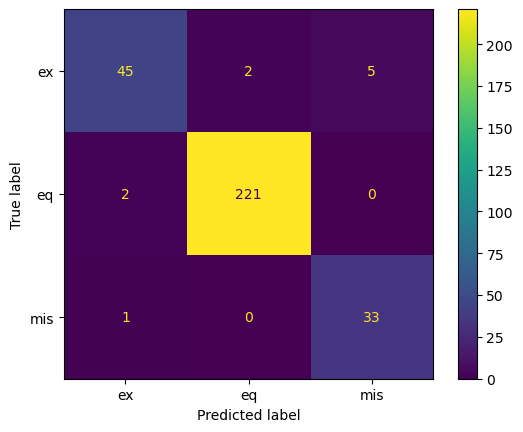

In [22]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=le.classes_)
display.plot()

In [23]:
f1_score(y_test, y_pred_test, average='macro')

0.9358993522670652

# Feature importance

In [24]:
import matplotlib.pyplot as plt

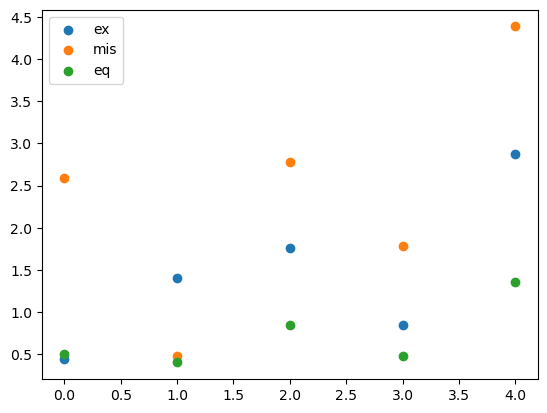

In [25]:
x = np.arange(0, 5)
plt.scatter(x, abs(model.coef_[0, :]), label=le.classes_[0])
plt.scatter(x, abs(model.coef_[2, :]), label=le.classes_[2])
plt.scatter(x, abs(model.coef_[1, :]), label=le.classes_[1])
plt.legend()

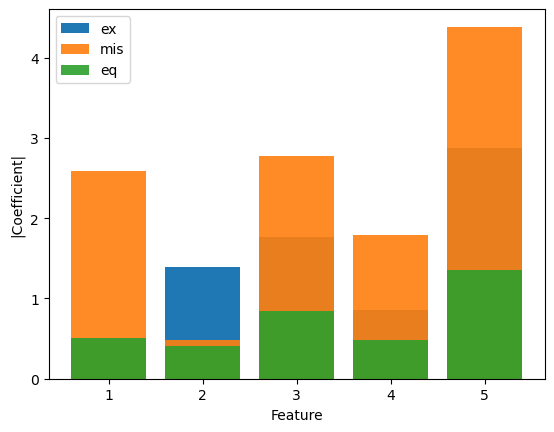

In [26]:
plt.bar(x+1, abs(model.coef_[0, :]), label=le.classes_[0])
plt.bar(x+1, abs(model.coef_[2, :]), label=le.classes_[2], alpha=0.9)
plt.bar(x+1, abs(model.coef_[1, :]), label=le.classes_[1], alpha=0.9)
plt.ylabel("|Coefficient|")
plt.xlabel("Feature")
plt.legend()